In [ ]:
import pandas as pd

# read movies data and print head   
movies_df = pd.read_csv('ml-25m/movies.csv')
print("Movies data loaded. Sample:")
print(movies_df.head())

total_movies = len(movies_df)
print(f"Total number of movies: {total_movies}")

ratings_df = pd.read_csv('ml-25m/ratings.csv')
print("Ratings data loaded. Sample:")
print(ratings_df.head())

total_ratings = len(ratings_df)
print(f"Total number of ratings: {total_ratings}")

genonmes_df = pd.read_csv('ml-25m/genome-tags.csv')
genome_scores_df = pd.read_csv('ml-25m/genome-scores.csv')

tags_df = pd.read_csv('ml-25m/tags.csv')
unique_tags = tags_df['tag'].nunique()
print(f"Total number of unique tags: {unique_tags}")

print("Total number of genome tags:", len(genonmes_df))
print("Total number of genome scores:", len(genome_scores_df))

joined_df = pd.merge(genome_scores_df, genonmes_df, on='tagId')

joined_df = pd.merge(joined_df, movies_df, on='movieId')

print("Joined DataFrame sample:")
print(joined_df.head())

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

# Load genome scores: columns 'movieId', 'tagId', 'relevance'
genome_scores = genome_scores_df[['movieId', 'tagId', 'relevance']].copy()

# Pivot to movie × tag matrix
movie_tag_matrix = genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

# Optional: Normalize data if needed (KMeans often works fine without)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# movie_tag_matrix_scaled = scaler.fit_transform(movie_tag_matrix)

# Fit KMeans for 50 clusters
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
movie_clusters = kmeans.fit_predict(movie_tag_matrix)

# Add cluster label to DataFrame
movie_tag_matrix['cluster'] = movie_clusters

# Example: Save clusters or merge with movies.csv
movie_clusters_df = movie_tag_matrix[['cluster']].reset_index()

print(movie_clusters_df.head())

In [75]:
# Count number of movies in each cluster
cluster_counts = movie_clusters_df['cluster'].value_counts().sort_index()

print(cluster_counts)

# number of distinct movies in genome scores
distinct_movies = genome_scores['movieId'].nunique()
print(f"Number of distinct movies in genome scores: {distinct_movies}")

cluster
0     135
1     273
2     441
3     692
4     564
5     149
6     129
7     373
8     189
9     382
10    481
11    224
12    144
13    204
14    364
15    313
16    360
17    780
18    238
19    285
20    241
21    302
22    177
23    313
24    259
25     74
26    274
27    157
28    210
29    465
30    235
31    314
32    178
33    133
34    163
35    247
36    233
37    184
38    306
39    257
40    201
41    120
42    314
43    222
44    316
45    111
46    158
47    198
48    355
49    379
Name: count, dtype: int64
Number of distinct movies in genome scores: 13816


In [ ]:
# Add cluster info to ratings based on movieId
ratings_with_cluster = ratings_df.merge(
    movie_clusters_df[['movieId', 'cluster']],
    on='movieId',
    how='left'
)

# Optionally drop ratings for movies without a cluster assignment
ratings_with_cluster = ratings_with_cluster.dropna(subset=['cluster'])

# Make sure cluster is integer type if needed
ratings_with_cluster['cluster'] = ratings_with_cluster['cluster'].astype(int)

print("Ratings with cluster info sample:")
print(ratings_with_cluster.head())


In [76]:
import numpy as np

np.random.seed(42)

coverage_target = 0.95

# Store selected users per run per cluster
clusters_user_selections = {}

for cluster_label in sorted(movie_clusters_df['cluster'].unique()):
    print(f"\n🔍 Processing cluster {cluster_label}")
    
    cluster_movies = movie_clusters_df[movie_clusters_df['cluster'] == cluster_label]['movieId'].unique()
    n_movies = len(cluster_movies)
    
    cluster_ratings = ratings_with_cluster[ratings_with_cluster['cluster'] == cluster_label]
    user_groups = cluster_ratings.groupby('userId')
    
    user_ids = list(user_groups.groups.keys())
    
    cumulative_selected_users = set()
    cumulative_covered_movies = set()
    
    # Initialize list to hold sets of selected users per run
    clusters_user_selections[cluster_label] = []
    
    run = 0
    while len(cumulative_covered_movies) / n_movies < coverage_target:
        run += 1
        np.random.shuffle(user_ids)
        
        covered_movies_shuffle = set()
        selected_users_shuffle = set()
        
        for user_id in user_ids:
            user_data = user_groups.get_group(user_id)
            covered_movies_shuffle.update(user_data['movieId'].unique())
            selected_users_shuffle.add(user_id)
            if len(covered_movies_shuffle) / n_movies >= 0.80:
                break
        
        # Update cumulative covered movies and users
        cumulative_selected_users.update(selected_users_shuffle)
        cumulative_covered_movies.update(covered_movies_shuffle)
        
        # Save selected users of this run
        clusters_user_selections[cluster_label].append(selected_users_shuffle)
        
        coverage_cumulative = len(cumulative_covered_movies) / n_movies
        print(f"   ➤ Run {run}: Selected {len(selected_users_shuffle)} users, cumulative unique movies covered so far: {len(cumulative_covered_movies)} ({coverage_cumulative:.2%})")

    print(f"   ➤ Total cumulative proportion of movies covered after {run} reshuffles: {len(cumulative_covered_movies) / n_movies:.2%}")

print("\n✅ Done: Cumulative movie coverage target reached for all clusters.")



🔍 Processing cluster 0
   ➤ Run 1: Selected 108 users, cumulative unique movies covered so far: 114 (84.44%)
   ➤ Run 2: Selected 261 users, cumulative unique movies covered so far: 123 (91.11%)
   ➤ Run 3: Selected 223 users, cumulative unique movies covered so far: 126 (93.33%)
   ➤ Run 4: Selected 126 users, cumulative unique movies covered so far: 129 (95.56%)
   ➤ Total cumulative proportion of movies covered after 4 reshuffles: 95.56%

🔍 Processing cluster 1
   ➤ Run 1: Selected 925 users, cumulative unique movies covered so far: 220 (80.59%)
   ➤ Run 2: Selected 687 users, cumulative unique movies covered so far: 241 (88.28%)
   ➤ Run 3: Selected 677 users, cumulative unique movies covered so far: 250 (91.58%)
   ➤ Run 4: Selected 868 users, cumulative unique movies covered so far: 258 (94.51%)
   ➤ Run 5: Selected 444 users, cumulative unique movies covered so far: 258 (94.51%)
   ➤ Run 6: Selected 708 users, cumulative unique movies covered so far: 262 (95.97%)
   ➤ Total cum

In [41]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Enable test mode to only process the first subselection per cluster
test_mode = True

# Store results
cluster_rules = {}

# Parameters
initial_min_support = 0.01
support_decay = 0.8
max_iterations = 200
target_antecedent_coverage = 0.95

for cluster_label, user_subsets in clusters_user_selections.items():
    print(f"\n🔍 Mining rules for cluster {cluster_label}")
    cluster_rules[cluster_label] = []
    
    cluster_movies = set(movie_clusters_df[movie_clusters_df['cluster'] == cluster_label]['movieId'])
    
    for subset_idx, user_set in enumerate(user_subsets):
        print(f" ➤ Subselection {subset_idx + 1}: {len(user_set)} users")

        subset_ratings = ratings_with_cluster[
            (ratings_with_cluster['cluster'] == cluster_label) &
            (ratings_with_cluster['userId'].isin(user_set)) &
            (ratings_with_cluster['rating'] >= 4.0)  # Treat 4+ as "liked"
        ]
        
        all_liked_movies = set(subset_ratings['movieId'].unique())
        coverage_goal = target_antecedent_coverage * len(all_liked_movies)

        used_ratings = subset_ratings.copy()
        used_users = set(used_ratings['userId'].unique())

        all_rules = []
        seen_antecedents = set()
        min_support = initial_min_support

        # For coverage tracking
        no_coverage_increase_counter = 0
        previous_coverage = 0
        
        for iteration in range(1, max_iterations + 1):
            transactions = (
                used_ratings.groupby('userId')['movieId']
                .apply(list)
                .tolist()
            )
            
            if not transactions:
                print("   ⚠ No more transactions left.")
                break

            te = TransactionEncoder()
            te_data = te.fit(transactions).transform(transactions)
            df_te = pd.DataFrame(te_data, columns=te.columns_)
            
            # Run FP-Growth
            frequent_itemsets = fpgrowth(df_te, min_support=min_support, use_colnames=True, max_len=3)
            if frequent_itemsets.empty:
                min_support *= support_decay
                print(f"   🔁 No itemsets found, decaying support to {min_support:.4f}")
                
                no_coverage_increase_counter += 1
                if no_coverage_increase_counter >= 5:
                    print(f"   ⚠ No coverage increase for 5 consecutive iterations. Stopping early.")
                    break
                continue
            
            # Extract rules with positive lift
            rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
            if rules.empty:
                min_support *= support_decay
                print(f"   🔁 No positive-lift rules found, support → {min_support:.4f}")
                
                no_coverage_increase_counter += 1
                if no_coverage_increase_counter >= 5:
                    print(f"   ⚠ No coverage increase for 5 consecutive iterations. Stopping early.")
                    break
                continue

            # Save rules
            rules['subselection_index'] = subset_idx
            rules['iteration'] = iteration
            rules['fraction_of_subset_used'] = len(used_users) / len(user_set)
            all_rules.append(rules)

            # Update seen antecedents
            new_antecedents = set().union(*rules['antecedents'])
            seen_antecedents.update(new_antecedents)

            # Check coverage of seen antecedents
            coverage = len(seen_antecedents.intersection(all_liked_movies))
            print(f"   ✅ Iter {iteration}: Rules found. Antecedent coverage: {coverage}/{len(all_liked_movies)} ({coverage / len(all_liked_movies):.2%})")

            # Check if coverage increased
            if coverage > previous_coverage:
                no_coverage_increase_counter = 0
            else:
                no_coverage_increase_counter += 1

            previous_coverage = coverage

            if no_coverage_increase_counter >= 5:
                print(f"   ⚠ No coverage increase for 5 consecutive iterations. Stopping early.")
                break
            
            if coverage >= coverage_goal:
                print("   🎯 Coverage goal reached.")
                break

            # Filter out users who only liked seen antecedent movies
            keep_users = []
            for user_id, group in used_ratings.groupby('userId'):
                liked = set(group['movieId'].unique())
                if liked - seen_antecedents:
                    keep_users.append(user_id)

            used_ratings = used_ratings[used_ratings['userId'].isin(keep_users)]
            used_users = set(keep_users)

        if all_rules:
            result_df = pd.concat(all_rules, ignore_index=True)
            result_df['cluster'] = cluster_label
            cluster_rules[cluster_label].append(result_df)

        # 💡 Exit after first subset if in test mode
        if test_mode:
            print("   🧪 Test mode active: stopping after first subselection.")
            break

print("\n✅ Iterative FP-Growth rule mining completed.")



🔍 Mining rules for cluster 0
 ➤ Subselection 1: 108 users
   ✅ Iter 1: Rules found. Antecedent coverage: 86/86 (100.00%)
   🎯 Coverage goal reached.
   🧪 Test mode active: stopping after first subselection.

🔍 Mining rules for cluster 1
 ➤ Subselection 1: 925 users
   ✅ Iter 1: Rules found. Antecedent coverage: 70/194 (36.08%)
   ✅ Iter 2: Rules found. Antecedent coverage: 132/194 (68.04%)
   ✅ Iter 3: Rules found. Antecedent coverage: 192/194 (98.97%)
   🎯 Coverage goal reached.
   🧪 Test mode active: stopping after first subselection.

🔍 Mining rules for cluster 2
 ➤ Subselection 1: 259 users
   ✅ Iter 1: Rules found. Antecedent coverage: 104/242 (42.98%)
   ✅ Iter 2: Rules found. Antecedent coverage: 239/242 (98.76%)
   🎯 Coverage goal reached.
   🧪 Test mode active: stopping after first subselection.

🔍 Mining rules for cluster 3
 ➤ Subselection 1: 565 users
   ✅ Iter 1: Rules found. Antecedent coverage: 5/353 (1.42%)
   ✅ Iter 2: Rules found. Antecedent coverage: 5/353 (1.42%)
  

In [ ]:
import numpy as np

# Concatenate all mined rules
all_rules_df = pd.concat([df for cluster_dfs in cluster_rules.values() for df in cluster_dfs], ignore_index=True)

best_rules_df = all_rules_df.loc[
    all_rules_df.groupby('antecedents')['confidence'].idxmax()
].reset_index(drop=True)

print(f"\nKept {len(best_rules_df)} rules, one per unique antecedent.")



Kept 161183 rules, one per unique antecedent.


In [61]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import numpy as np

# Prepare empty lists to collect results aligned with best_rules_df
supports = []
confidences = []
lifts = []

# Process cluster by cluster
for cluster_label in best_rules_df["cluster"].unique():
    print(f"Evaluating rules on full data for cluster {cluster_label}...")

    cluster_rules = best_rules_df[best_rules_df['cluster'] == cluster_label].reset_index()

    # Filter cluster ratings with rating >= 4
    cluster_ratings = ratings_with_cluster[
        (ratings_with_cluster['cluster'] == cluster_label) & 
        (ratings_with_cluster['rating'] >= 4.0)
    ]

    # Build transaction list for cluster users
    transactions = cluster_ratings.groupby('userId')['movieId'].apply(list).tolist()

    if len(transactions) == 0:
        # No data for this cluster, fill zeros for all its rules
        supports.extend([0] * len(cluster_rules))
        confidences.extend([0] * len(cluster_rules))
        lifts.extend([0] * len(cluster_rules))
        continue

    # Encode transactions
    te = TransactionEncoder()
    te_data = te.fit(transactions).transform(transactions)
    df_te = pd.DataFrame(te_data, columns=te.columns_)

    # For each rule in this cluster, compute metrics
    for idx, rule in cluster_rules.iterrows():
        antecedent_list = list(rule['antecedents'])
        consequent_list = list(rule['consequents'])

        # Check if antecedents and consequents exist in df_te columns
        if not all(a in df_te.columns for a in antecedent_list) or not all(c in df_te.columns for c in consequent_list):
            supports.append(0)
            confidences.append(0)
            lifts.append(0)
            continue

        support = df_te[antecedent_list + consequent_list].all(axis=1).mean()
        antecedent_support = df_te[antecedent_list].all(axis=1).mean()
        consequent_support = df_te[consequent_list].all(axis=1).mean()

        confidence = support / antecedent_support if antecedent_support > 0 else 0
        lift = confidence / consequent_support if consequent_support > 0 else 0

        supports.append(support)
        confidences.append(confidence)
        lifts.append(lift)

# Add computed metrics as new columns in best_rules_df
best_rules_df['support_full_cluster'] = supports
best_rules_df['confidence_full_cluster'] = confidences
best_rules_df['lift_full_cluster'] = lifts


Evaluating rules on full data for cluster 0...
Evaluating rules on full data for cluster 29...
Evaluating rules on full data for cluster 30...
Evaluating rules on full data for cluster 31...
Evaluating rules on full data for cluster 32...
Evaluating rules on full data for cluster 34...
Evaluating rules on full data for cluster 33...
Evaluating rules on full data for cluster 24...
Evaluating rules on full data for cluster 23...
Evaluating rules on full data for cluster 25...
Evaluating rules on full data for cluster 26...
Evaluating rules on full data for cluster 22...
Evaluating rules on full data for cluster 28...
Evaluating rules on full data for cluster 27...
Evaluating rules on full data for cluster 42...
Evaluating rules on full data for cluster 43...
Evaluating rules on full data for cluster 44...
Evaluating rules on full data for cluster 40...
Evaluating rules on full data for cluster 39...
Evaluating rules on full data for cluster 41...
Evaluating rules on full data for cluster


📊 Cluster-wise Rule Statistics and Visualizations (3 random clusters + overall)


--- Cluster 29 ---
Movies in cluster: 465
Unique movies in antecedents: 299 (64.30% of cluster movies)
Confidence - mean: 0.309, median: 0.250
Lift       - mean: 96.706, median: 33.071


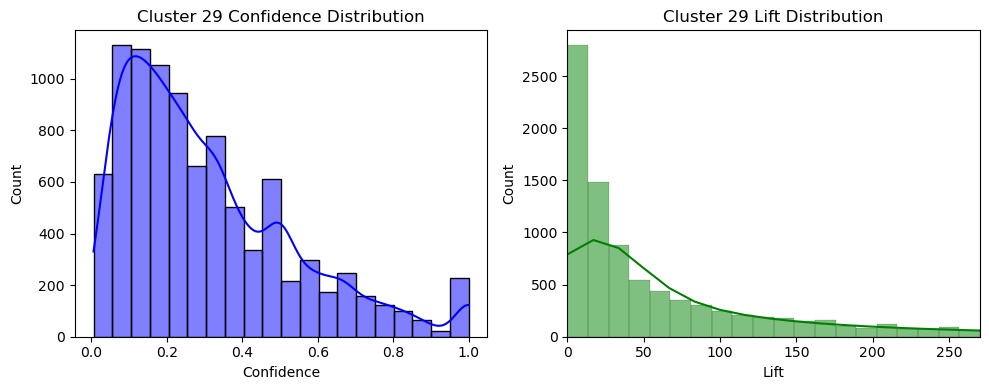


--- Cluster 39 ---
Movies in cluster: 257
Unique movies in antecedents: 184 (71.60% of cluster movies)
Confidence - mean: 0.437, median: 0.389
Lift       - mean: 22.991, median: 13.772


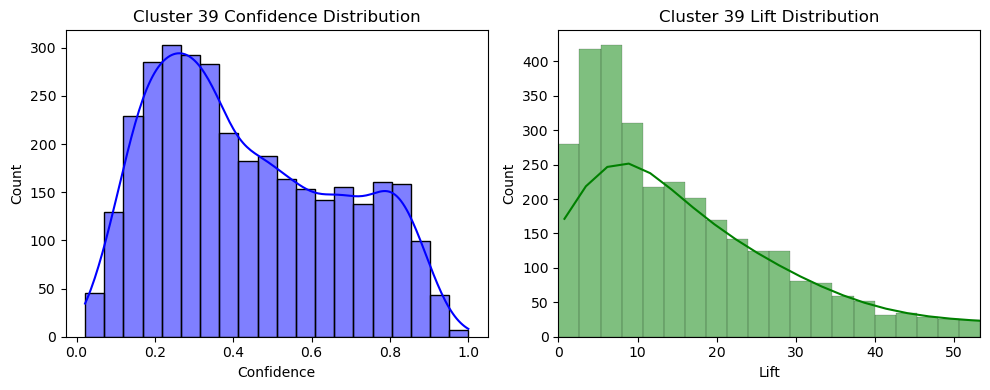


--- Cluster 16 ---
Movies in cluster: 360
Unique movies in antecedents: 26 (7.22% of cluster movies)
Confidence - mean: 0.450, median: 0.417
Lift       - mean: 39.153, median: 30.280


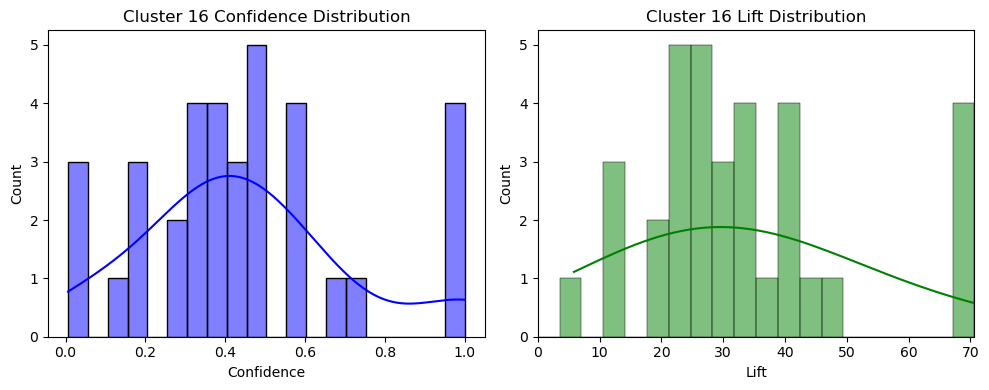


--- Overall View Across All Clusters ---
Total unique movies across all clusters: 13816
Unique movies in antecedents across all clusters: 6539 (47.33% of all movies)
Confidence - mean: 0.364, median: 0.330
Lift       - mean: 78.844, median: 17.825


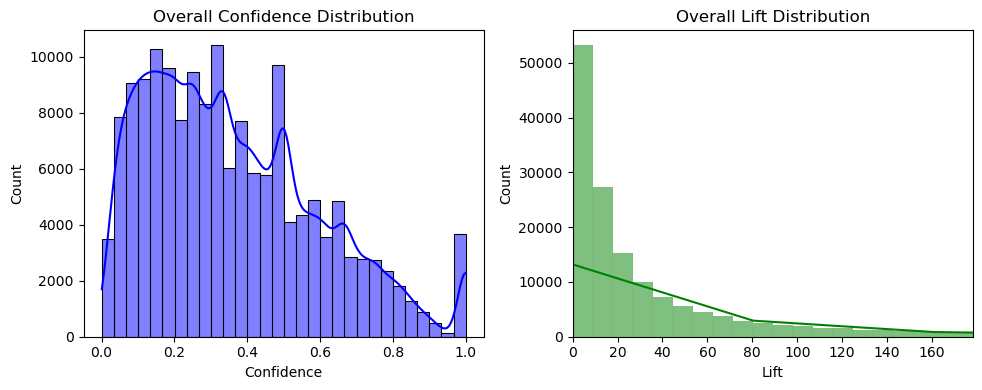

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n📊 Cluster-wise Rule Statistics and Visualizations (3 random clusters + overall)\n")

# Select 3 random clusters (or fewer if less than 3 exist)
unique_clusters = best_rules_df['cluster'].unique()
n_sample = min(3, len(unique_clusters))
sample_clusters = np.random.choice(unique_clusters, n_sample, replace=False)

for cluster_label in sample_clusters:
    print(f"\n--- Cluster {cluster_label} ---")

    cluster_rules = best_rules_df[best_rules_df['cluster'] == cluster_label]

    cluster_movies = set(movie_clusters_df[movie_clusters_df['cluster'] == cluster_label]['movieId'])
    total_cluster_movies = len(cluster_movies)

    antecedent_movies = set()
    for ants in cluster_rules['antecedents']:
        antecedent_movies.update(ants)
    unique_ants = len(antecedent_movies)

    print(f"Movies in cluster: {total_cluster_movies}")
    print(f"Unique movies in antecedents: {unique_ants} ({unique_ants/total_cluster_movies:.2%} of cluster movies)")

    print(f"Confidence - mean: {cluster_rules['confidence_full_cluster'].mean():.3f}, median: {cluster_rules['confidence_full_cluster'].median():.3f}")
    print(f"Lift       - mean: {cluster_rules['lift_full_cluster'].mean():.3f}, median: {cluster_rules['lift_full_cluster'].median():.3f}")

    lift_90 = cluster_rules['lift_full_cluster'].quantile(0.90)
    lift_xlim = lift_90 * 1.05

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(cluster_rules['confidence_full_cluster'], bins=20, kde=True, color='blue')
    plt.title(f'Cluster {cluster_label} Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    plt.subplot(1,2,2)
    bins = np.linspace(0, lift_xlim, 21)  # 20 bins means 21 edges
    sns.histplot(cluster_rules['lift_full_cluster'], bins=bins, kde=True, color='green')
    plt.title(f'Cluster {cluster_label} Lift Distribution')
    plt.xlabel('Lift')
    plt.ylabel('Count')
    plt.xlim(0, lift_xlim)

    plt.tight_layout()
    plt.show()

# Overall view across all clusters
print("\n--- Overall View Across All Clusters ---")

all_antecedents = set()
for ants in best_rules_df['antecedents']:
    all_antecedents.update(ants)

all_cluster_movies = set(movie_clusters_df['movieId'])
print(f"Total unique movies across all clusters: {len(all_cluster_movies)}")
print(f"Unique movies in antecedents across all clusters: {len(all_antecedents)} ({len(all_antecedents)/len(all_cluster_movies):.2%} of all movies)")

print(f"Confidence - mean: {best_rules_df['confidence_full_cluster'].mean():.3f}, median: {best_rules_df['confidence_full_cluster'].median():.3f}")
print(f"Lift       - mean: {best_rules_df['lift_full_cluster'].mean():.3f}, median: {best_rules_df['lift_full_cluster'].median():.3f}")

lift_90_overall = best_rules_df['lift_full_cluster'].quantile(0.90)
lift_xlim_overall = lift_90_overall * 1.05

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(best_rules_df['confidence_full_cluster'], bins=30, kde=True, color='blue')
plt.title('Overall Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')

plt.subplot(1,2,2)
bins = np.linspace(0, lift_xlim_overall, 21)  # 20 bins over the limited x-axis
sns.histplot(best_rules_df['lift_full_cluster'], bins=bins, kde=True, color='green')
plt.title('Overall Lift Distribution')
plt.xlabel('Lift')
plt.ylabel('Count')
plt.xlim(0, lift_xlim_overall)

plt.tight_layout()
plt.show()
